In [1]:
# local install includes
local_venv = '/udd0/litterbox/venv/bin/activate_this.py'
execfile(local_venv, dict(__file__=local_venv))

%matplotlib inline
import numpy as np
from astropy import units as u
import astropy.coordinates as coords

In [2]:
hipp_ylib = {
'RA': '15h11m41.30861s',
'DEC': '-06d00m41.3737',
'parallax': 2.06*u.mas,
'proper_motion': (-5.59, -18.48)*(u.mas/u.yr),
'radial_velocity': -7.*(u.km/u.s)
    }

distance = (hipp_ylib['parallax']).to(u.kpc, u.parallax())
hipp_ylib['distance'] = distance

target = coords.ICRS(hipp_ylib['RA'], hipp_ylib['DEC'],
                     distance=hipp_ylib['distance'],
                     pm_ra_cosdec=hipp_ylib['proper_motion'][0],
                     pm_dec=hipp_ylib['proper_motion'][1],
                     radial_velocity=hipp_ylib['radial_velocity'])
hipp_ylib['ICRS'] = target
hipp_ylib['Galactic'] = target.transform_to(coords.Galactic)

In [3]:
vera_ylib = {
'RA': '15h11m41.299s',
'DEC': '-06d00m41.462s',
'parallax': 0.855*u.mas,
'proper_motion': (-10.153, -15.020)*(u.mas/u.yr),
'radial_velocity': 14.*(u.km/u.s)  # LSR
    }

distance = (vera_ylib['parallax']).to(u.kpc, u.parallax())
vera_ylib['distance'] = distance

target = coords.ICRS(vera_ylib['RA'], vera_ylib['DEC'],
                     distance=vera_ylib['distance'],
                     pm_ra_cosdec=vera_ylib['proper_motion'][0],
                     pm_dec=vera_ylib['proper_motion'][1],
                     radial_velocity=vera_ylib['radial_velocity'])
vera_ylib['ICRS'] = target
vera_ylib['Galactic'] = target.transform_to(coords.Galactic)

v_bary = vera_ylib['ICRS'].transform_to(coords.LSR).v_bary
Usun, Vsun, Wsun = np.asarray(v_bary.d_xyz.value)

l = vera_ylib['Galactic'].l.rad
b = vera_ylib['Galactic'].b.rad

# vlsr = vbsr + (Usun*cos(l)*cos(b) + Vsun*sin(l)*cos(b) + Wsun*sin(b)
vera_ylib['radial_velocity'] = vera_ylib['radial_velocity'].value - (Usun * np.cos(l) * np.cos(b) +
                                                                     Vsun * np.sin(l) * np.cos(b) +
                                                                     Wsun * np.sin(b))

vera_ylib['radial_velocity'] = vera_ylib['radial_velocity']*(u.km/u.s)

In [4]:
import matplotlib.pylab as plt
from galpy.orbit import Orbit
import galpy

In [5]:
MWPotential2014=galpy.potential.MWPotential2014
ts = np.linspace(0,1.,10000)*u.Gyr


Sol = coords.Galactocentric()
Sol_orbit = Orbit(vxvv=[Sol.galcen_distance,
                        Sol.galcen_v_sun.d_x,
                        Sol.galcen_v_sun.d_y,
                        Sol.z_sun,
                        Sol.galcen_v_sun.d_z,
                        0.*u.deg])
Sol_orbit.flip(inplace=True) # velocities are minus the original velocities; useful for quick backward integration

In [6]:
target_gal = hipp_ylib['ICRS'].transform_to(coords.Galactic)
target_gal.representation = 'cartesian'
target_orbit= Orbit(vxvv=[hipp_ylib['Galactic'].l,
                          hipp_ylib['Galactic'].b,
                          hipp_ylib['Galactic'].distance,
                          target_gal.U,
                          target_gal.V,
                          target_gal.W],
                    solarmotion='dehnen',
                    lb=True, uvw=True,
                    ro=Sol.galcen_distance,
                    vo=(Sol.galcen_v_sun.d_y - target.transform_to(coords.LSR).v_bary.d_y))
target_orbit.flip(inplace=True) # velocities are minus the original velocities; useful for quick backward integration
hipp_ylib['orbit'] = target_orbit

In [7]:
target_gal = vera_ylib['ICRS'].transform_to(coords.Galactic)
target_gal.representation = 'cartesian'
target_orbit= Orbit(vxvv=[vera_ylib['Galactic'].l,
                          vera_ylib['Galactic'].b,
                          vera_ylib['Galactic'].distance,
                          target_gal.U,
                          target_gal.V,
                          target_gal.W],
                    solarmotion='dehnen',
                    lb=True, uvw=True,
                    ro=Sol.galcen_distance,
                    vo=(Sol.galcen_v_sun.d_y - target.transform_to(coords.LSR).v_bary.d_y))
target_orbit.flip(inplace=True) # velocities are minus the original velocities; useful for quick backward integration
vera_ylib['orbit'] = target_orbit

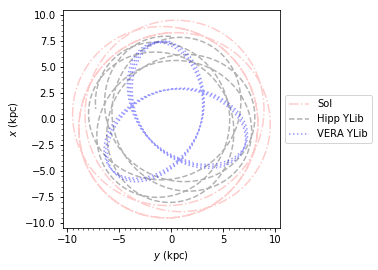

In [8]:
Sol_orbit.integrate(ts, MWPotential2014, method='rk4_c')
Sol_orbit.plot(d1='y', d2='x', color='r', alpha=0.2, linestyle='-.', label='Sol')

hipp_ylib['orbit'].integrate(ts, MWPotential2014, method='rk4_c')
hipp_ylib['orbit'].plot(d1='y', d2='x', color='k', alpha=0.3, linestyle='--', label='Hipp YLib', overplot=True)

vera_ylib['orbit'].integrate(ts, MWPotential2014, method='rk4_c')
vera_ylib['orbit'].plot(d1='y', d2='x', color='b', alpha=0.4, linestyle=':', label='VERA YLib', overplot=True)


plt.axis('square')
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left', ncol=1);
plt.savefig('YLib_VERA_yx.png', type="png", dpi=300)

In [9]:
PSP = galpy.potential.PowerSphericalPotentialwCutoff(alpha=1.8,rc=0.2375,normalize=0.05)
NFWP = galpy.potential.NFWPotential(a=2.0,normalize=.35)
MNP = galpy.potential.MiyamotoNagaiPotential(a=0.9,b=0.027,normalize=.27)
MWP = [PSP, MNP, NFWP]

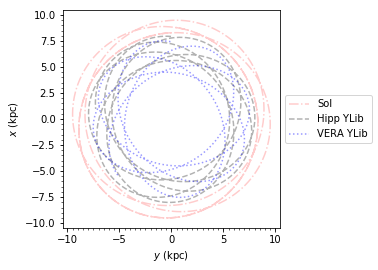

In [10]:
Sol_orbit.integrate(ts, MWPotential2014, method='rk4_c')
Sol_orbit.plot(d1='y', d2='x', color='r', alpha=0.2, linestyle='-.', label='Sol')

hipp_ylib['orbit'].integrate(ts, MWPotential2014, method='rk4_c')
hipp_ylib['orbit'].plot(d1='y', d2='x', color='k', alpha=0.3, linestyle='--', label='Hipp YLib', overplot=True)

vera_ylib['orbit'].integrate(ts, MWP, method='rk4_c')
vera_ylib['orbit'].plot(d1='y', d2='x', color='b', alpha=0.4, linestyle=':', label='VERA YLib', overplot=True)


plt.axis('square')
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left', ncol=1);
plt.savefig('YLib_VERA_mwp_yx.png', type="png", dpi=300)

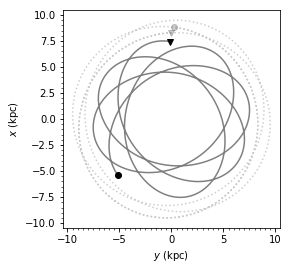

In [21]:
Sol_orbit.plot(d1='y', d2='x', color='k', alpha=0.2, linestyle=':', label='Sol')
plt.plot(Sol_orbit.y(ts)[0], Sol_orbit.x(ts)[0], 'kv', alpha=0.2, label='Sol now')
plt.plot(Sol_orbit.y(ts)[-1], Sol_orbit.x(ts)[-1], 'ko', alpha=0.2, label='Sol 1Gyr ago')

vera_ylib['orbit'].plot(d1='y', d2='x', color='k', alpha=0.5, linestyle='-', label='YLib', overplot=True)
plt.plot(vera_ylib['orbit'].y(ts)[0], vera_ylib['orbit'].x(ts)[0], 'kv', label='YLib now')
plt.plot(vera_ylib['orbit'].y(ts)[-1], vera_ylib['orbit'].x(ts)[-1], 'ko', label='YLib 1Gyr ago')


plt.axis('square')
#plt.legend(bbox_to_anchor=(1, 0.5), loc='center left', ncol=1);
plt.savefig('YLIB_XY.png', type="png", dpi=300)

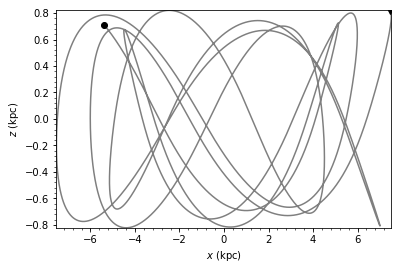

In [22]:
vera_ylib['orbit'].plot(d1='x', d2='z', color='k', alpha=0.5, linestyle='-')
plt.plot(vera_ylib['orbit'].x(ts)[0], vera_ylib['orbit'].z(ts)[0], 'kv', label='YLib now')
plt.plot(vera_ylib['orbit'].x(ts)[-1], vera_ylib['orbit'].z(ts)[-1], 'ko', label='YLib 1Gyr ago')


#plt.legend(bbox_to_anchor=(1, 0.5), loc='center left', ncol=1);
plt.savefig('YLIB_XZ.png', type="png", dpi=300)

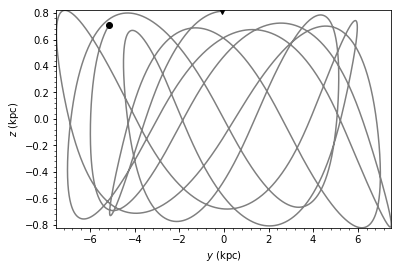

In [23]:
vera_ylib['orbit'].plot(d1='y', d2='z', color='k', alpha=0.5, linestyle='-')
plt.plot(vera_ylib['orbit'].y(ts)[0], vera_ylib['orbit'].z(ts)[0], 'kv', label='YLib now')
plt.plot(vera_ylib['orbit'].y(ts)[-1], vera_ylib['orbit'].z(ts)[-1], 'ko', label='YLib 1Gyr ago')


#plt.legend(bbox_to_anchor=(1, 0.5), loc='center left', ncol=1);
plt.savefig('YLIB_YZ.png', type="png", dpi=300)

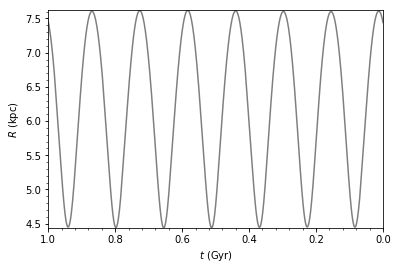

In [25]:
target_orbit.plot(d1='t', d2='R', color='k', alpha=0.5, linestyle='-')
plt.gca().invert_xaxis()
plt.savefig('YLIB_Rt.png', type="png", dpi=300)

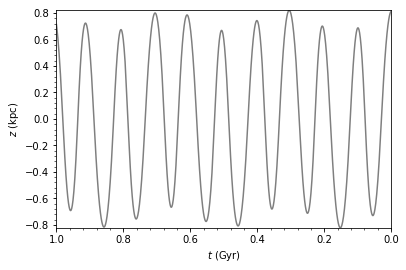

In [26]:
target_orbit.plot(d1='t', d2='z', color='k', alpha=0.5, linestyle='-')
plt.gca().invert_xaxis()
plt.savefig('YLIB_Zt.png', type="png", dpi=300)